In [109]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [110]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [111]:
X_moons, y_moons = datasets.make_moons(n_samples=1000, 
                                       noise=0.12, 
                                       random_state=42)

In [112]:
# print(f"First 5 X features:\n{X_moons[:5]}")
# print(f"\nFirst 5 y labels:\n{y_moons[:5]}")

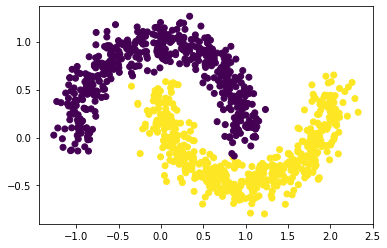

In [113]:
plt.scatter(x=X_moons[:,0],
            y=X_moons[:,1],
            c=y_moons);

## 1. Make Tensors and train test spilts

In [114]:
import torch

X_moons = torch.from_numpy(X_moons).type(torch.float)
y_moons = torch.from_numpy(y_moons).type(torch.float)

In [115]:
#X_moons[:5],y_moons[:5]

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_moons, 
                                                    y_moons, 
                                                    test_size=0.2,
                                                    random_state=42)

In [117]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model

In [118]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [119]:
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [120]:
model = MoonModel().to(device)
model

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): ReLU()
  )
)

## 3. Get a loss function and optimizer 

In [121]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.6)

## 4. Training loop

In [122]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [123]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


epoch = 200

for epoch in range(epoch):

    model.train()

    # Label prediction
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss 
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing loop
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.69505, Accuracy: 37.88% | Test Loss: 0.69314, Test Accuracy: 50.5
Epoch: 10 | Loss: 0.66803, Accuracy: 54.75% | Test Loss: 0.66566, Test Accuracy: 68.0
Epoch: 20 | Loss: 0.59162, Accuracy: 76.88% | Test Loss: 0.59779, Test Accuracy: 73.0


Epoch: 30 | Loss: 0.53647, Accuracy: 82.88% | Test Loss: 0.53911, Test Accuracy: 80.0
Epoch: 40 | Loss: 0.50202, Accuracy: 85.62% | Test Loss: 0.50097, Test Accuracy: 86.0
Epoch: 50 | Loss: 0.48053, Accuracy: 87.38% | Test Loss: 0.47774, Test Accuracy: 87.5
Epoch: 60 | Loss: 0.46753, Accuracy: 88.25% | Test Loss: 0.46336, Test Accuracy: 88.5
Epoch: 70 | Loss: 0.45836, Accuracy: 89.12% | Test Loss: 0.45331, Test Accuracy: 91.0
Epoch: 80 | Loss: 0.45168, Accuracy: 89.88% | Test Loss: 0.44663, Test Accuracy: 90.5
Epoch: 90 | Loss: 0.44604, Accuracy: 90.12% | Test Loss: 0.44072, Test Accuracy: 90.5
Epoch: 100 | Loss: 0.44051, Accuracy: 90.62% | Test Loss: 0.43481, Test Accuracy: 90.5
Epoch: 110 | Loss: 0.43515, Accuracy: 90.88% | Test Loss: 0.42935, Test Accuracy: 91.5
Epoch: 120 | Loss: 0.42930, Accuracy: 91.62% | Test Loss: 0.42364, Test Accuracy: 91.5
Epoch: 130 | Loss: 0.42331, Accuracy: 92.12% | Test Loss: 0.41794, Test Accuracy: 92.0
Epoch: 140 | Loss: 0.41558, Accuracy: 93.00% | Tes

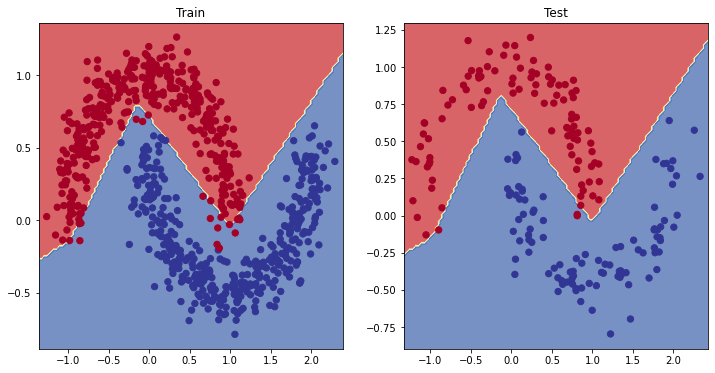

In [124]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train) 
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)